# Imports

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from torchsummary import summary

# Data generation

In [2]:

def generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius):
    domain = np.ones((N,N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    x, y = np.meshgrid(x, y)
    
    for i in range(numberOfCircles):
        overlap = True
        while overlap == True:
            xc = np.random.uniform(radius, domainLength - radius)
            yc = np.random.uniform(radius, domainLength - radius)
            
            mask = (x - xc)**2 + (y - yc)**2 < radius**2
            if ~np.any(domain[mask] == -1):
                overlap = False
        domain[mask] = -1
    return domain

def generateAnomolousDataInDomain(N, domainLength, numberOfCircles, radius, numberOfSquares):
    domain = np.ones((N,N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    x, y = np.meshgrid(x, y)
    
    for i in range(numberOfCircles):
        overlap = True
        while overlap == True:
            xc = np.random.uniform(radius, domainLength - radius)
            yc = np.random.uniform(radius, domainLength - radius)
            
            if i >= numberOfSquares:    
                mask = (x - xc)**2 + (y - yc)**2 < radius**2
            else:
                mask = x > xc - radius
                mask *= x < xc + radius
                mask *= y > yc - radius
                mask *= y < yc + radius
            if ~np.any(domain[mask] == -1):
                overlap = False
        domain[mask] = -1
    return domain

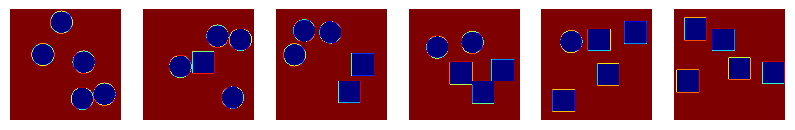

In [3]:
N = 128
domainLength = 1
numberOfCircles = 5
radius = 0.1

numberOfSamples = 200 # 640? #1280
numberOfAnomolousSamples = 128


normalSamples = torch.zeros((numberOfSamples, 1, N, N))
for i in range(numberOfSamples):
    normalSamples[i, 0] = torch.from_numpy(generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius)).to(torch.float32)
torch.save(normalSamples, "data/normalData.pt")

sampleList = []
anomalySamples = torch.zeros((numberOfSamples, 1, N, N))
for j in range(0, numberOfCircles+1): # 0 is not anomalous
    anomalySamples = torch.zeros((numberOfAnomolousSamples, 1, N, N))
    for i in range(numberOfAnomolousSamples):
        anomalySamples[i, 0] = torch.from_numpy(generateAnomolousDataInDomain(N, domainLength, numberOfCircles, radius, j)).to(torch.float32)
    torch.save(anomalySamples, "data/anomalyData" + str(j) + ".pt")
    sampleList.append(anomalySamples)

fig, ax = plt.subplots(1,6, figsize=(10,3))
for i in range(6):
    ax[i].imshow(sampleList[i][0,0], origin='lower', cmap='jet')
    ax[i].axis('off')
plt.show()

# Define dataset

In [4]:
class normalDataset(Dataset):
    def __init__(self):
        self.data = torch.load("data/normalData.pt")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
class anomalyDataset(Dataset):
    def __init__(self, degree):
        self.data = torch.load("data/anomalyData" + str(degree) + ".pt")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Define autoencoder architecture

In [5]:
# NN architecture
class autoencoder(torch.nn.Module):
    def __init__(self, depth, numberOfFilters, convolutionalLayers, bottleneckConvolutions=True):
        super().__init__()
        
        self.depth = depth
        self.convolutionalLayers = convolutionalLayers
        self.bottleneckConvolutions = bottleneckConvolutions
        
        FilterSizes = np.linspace(-1,depth-1, depth+1, dtype=np.int32)
        FilterSizes[1:] = 2**FilterSizes[1:] * numberOfFilters
        FilterSizes[0] = 1
               
        self.convDown = torch.nn.ModuleList()
        self.batchNormDown = torch.nn.ModuleList()
        self.activationDown = torch.nn.ModuleList()
        self.downsample = torch.nn.ModuleList()
        
        self.convBottleneck = torch.nn.ModuleList()
        self.batchNormBottleneck = torch.nn.ModuleList()
        self.activationBottleneck = torch.nn.ModuleList()
        
        self.convUp = torch.nn.ModuleList()
        self.batchNormUp = torch.nn.ModuleList()
        self.activationUp = torch.nn.ModuleList()
        self.upsample = torch.nn.ModuleList()
        
        for i in range(depth):
            # downsampling
            for j in range(convolutionalLayers):
                if j == 0:
                    self.convDown.append(torch.nn.Conv2d(FilterSizes[i], FilterSizes[i+1], kernel_size=3, stride=1, padding=1)) # ADD SECOND LAYER
                else:
                    self.convDown.append(torch.nn.Conv2d(FilterSizes[i+1], FilterSizes[i+1], kernel_size=3, stride=1, padding=1)) # ADD SECOND LAYER
                self.batchNormDown.append(torch.nn.BatchNorm2d(FilterSizes[i+1])) # TODO CHECK
                self.activationDown.append(torch.nn.PReLU(init=0.2)) # TODO CHECK
#                self.activationDown.append(torch.nn.LeakyReLU()) # TODO CHECK
                self.downsample.append(torch.nn.MaxPool2d(kernel_size=2, stride=2)) 
                
            # layers at bottleneck
            for j in range(convolutionalLayers):
                self.convBottleneck.append(torch.nn.Conv2d(FilterSizes[-1], FilterSizes[-1], kernel_size=3, stride=1, padding=1))
                self.batchNormBottleneck.append(torch.nn.BatchNorm2d(FilterSizes[-1])) # TODO CHECK
                self.activationBottleneck.append(torch.nn.PReLU(init=0.2)) # TODO CHECK
#                self.activationBottleneck.append(torch.nn.LeakyReLU()) # TODO CHECK

                
            # upsampling
            for j in range(convolutionalLayers):
                if j == 0:
                    self.convUp.append(torch.nn.Conv2d(FilterSizes[-i-1], FilterSizes[-i-2], kernel_size=3, stride=1, padding=1))
                else:
                    self.convUp.append(torch.nn.Conv2d(FilterSizes[-i-2], FilterSizes[-i-2], kernel_size=3, stride=1, padding=1))              
                self.batchNormUp.append(torch.nn.BatchNorm2d(FilterSizes[-i-2])) # TODO CHECK
                self.activationUp.append(torch.nn.PReLU(init=0.2)) # TODO CHECK
#                self.activationUp.append(torch.nn.LeakyReLU()) # TODO CHECK
            self.upsample.append(torch.nn.Upsample(scale_factor=2, mode='nearest')) # nearest instead of bilinear as field is not continuous
            
#            self.finalActivation = torch.nn.ReLU(inplace=True)
             
    def forward(self, x):
        y = x #* 2 - 1 # normalization
        
        # downsampling        
        for i in range(self.depth):
            for j in range(self.convolutionalLayers):
                y = self.activationDown[i * self.convolutionalLayers + j](self.batchNormDown[i * self.convolutionalLayers + j](self.convDown[i * self.convolutionalLayers + j](y)))
            y = self.downsample[i](y)
          
        # bottleneck
        if self.bottleneckConvolutions == True:
            for j in range(self.convolutionalLayers):
                y = self.activationBottleneck[j](self.batchNormBottleneck[j](self.convBottleneck[j](y)))
            
        # upsampling
        for i in range(self.depth):
            y = self.upsample[i](y)
            for j in range(self.convolutionalLayers):
                y = self.activationUp[i * self.convolutionalLayers + j](self.batchNormUp[i * self.convolutionalLayers + j](self.convUp[i * self.convolutionalLayers + j](y)))
           
#        self.finalActivation(y)
        return y    

# Define autoencoder architecture (3D)

In [6]:
## NN architecture
#class autoencoder3D(torch.nn.Module):
#    def __init__(self, depth, mapToFilters, convolutionalLayers, bottleneckConvolutions=True):
#        super().__init__()
#        
#        self.depth = depth
#        self.convolutionalLayers = convolutionalLayers
#        self.bottleneckConvolutions = bottleneckConvolutions
#        
#        FilterSizes = np.linspace(-1,depth-1, depth+1, dtype=np.int32)
#        FilterSizes[1:] = 2**FilterSizes[1:] * mapToFilters
#        FilterSizes[0] = 1
#        
#        self.convDown = torch.nn.ModuleList()
#        self.batchNormDown = torch.nn.ModuleList()
#        self.activationDown = torch.nn.ModuleList()
#        self.downsample = torch.nn.ModuleList()
#        
#        self.convBottleneck = torch.nn.ModuleList()
#        self.batchNormBottleneck = torch.nn.ModuleList()
#        self.activationBottleneck = torch.nn.ModuleList()
#        
#        self.convUp = torch.nn.ModuleList()
#        self.batchNormUp = torch.nn.ModuleList()
#        self.activationUp = torch.nn.ModuleList()
#        self.upsample = torch.nn.ModuleList()
#        
#        for i in range(depth):
#            # downsampling
#            for j in range(convolutionalLayers):
#                if j == 0:
#                    self.convDown.append(torch.nn.Conv3d(FilterSizes[i], FilterSizes[i+1], kernel_size=3, stride=1, padding=1, device=device)) # ADD SECOND LAYER
#                else:
#                    self.convDown.append(torch.nn.Conv3d(FilterSizes[i+1], FilterSizes[i+1], kernel_size=3, stride=1, padding=1, device=device)) # ADD SECOND LAYER
#                self.batchNormDown.append(torch.nn.BatchNorm3d(FilterSizes[i+1], device=device))
#                self.activationDown.append(torch.nn.PReLU(init=0.2, device=device))
#                self.downsample.append(torch.nn.MaxPool3d(kernel_size=2, stride=2)) # or make it learnable
#                
#            # layers at bottleneck
#            for j in range(convolutionalLayers):
#                self.convBottleneck.append(torch.nn.Conv3d(FilterSizes[-1], FilterSizes[-1], kernel_size=3, stride=1, padding=1, device=device))
#                self.batchNormBottleneck.append(torch.nn.BatchNorm3d(FilterSizes[-1], device=device))
#                self.activationBottleneck.append(torch.nn.PReLU(init=0.2, device=device)) 
#                
#            # upsampling
#            for j in range(convolutionalLayers):
#                if j == 0:
#                    self.convUp.append(torch.nn.Conv3d(FilterSizes[-i-1], FilterSizes[-i-2], kernel_size=3, stride=1, padding=1, device=device))
#                else:
#                    self.convUp.append(torch.nn.Conv3d(FilterSizes[-i-2], FilterSizes[-i-2], kernel_size=3, stride=1, padding=1, device=device))              
#                self.batchNormUp.append(torch.nn.BatchNorm3d(FilterSizes[-i-2], device=device))
#                self.activationUp.append(torch.nn.PReLU(init=0.2, device=device))
#            self.upsample.append(torch.nn.Upsample(scale_factor=2, mode='nearest')) # nearest instead of bilinear as field is not continuous
#            
#            self.finalActivation = torch.nn.ReLU(inplace=True)
#     
#    def forward(self, x):
#        y = x
#
#        # downsampling        
#        for i in range(self.depth):
#            for j in range(self.convolutionalLayers):
#                y = self.activationDown[i * self.convolutionalLayers + j](self.batchNormDown[i * self.convolutionalLayers + j](self.convDown[i * self.convolutionalLayers + j](y)))
#            y = self.downsample[i](y)
#          
#        # bottleneck
#        if self.bottleneckConvolutions == True:
#            for j in range(self.convolutionalLayers):
#                y = self.activationBottleneck[j](self.batchNormBottleneck[j](self.convBottleneck[j](y)))
#            
#        # upsampling
#        for i in range(self.depth):
#            y = self.upsample[i](y)
#            for j in range(self.convolutionalLayers):
#                y = self.activationUp[i * self.convolutionalLayers + j](self.batchNormUp[i * self.convolutionalLayers + j](self.convUp[i * self.convolutionalLayers + j](y)))
#           
#        self.finalActivation(y)
#        return y


# Main script

In [7]:
# TODO TUNE FOR LOWER VALIDATION ERROR + POTENTIALLY BETTER BOTTLENECK (CURRENT BEST 7.2e-3, 1.1e-2)
# INCREASE NUMBER OF GENERATED SAMPLES?
# POSTPROCESS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(2)

depth = 4
numberOfFilters = 3 #6
convolutionalLayers = 2 #3 # 2
epochs = 200 #100
lr = 5e-3 #1e-2
batchSize = 64 #32 #64
regularization = 1e-4 #1e-6 #1e-3 #1e-6

#numberOfFilters * (depth + 1) * (N / 2**depth)**2

dataset = normalDataset()
datasetTraining, datasetValidation = torch.utils.data.dataset.random_split(dataset, [0.9, 0.1])
dataloaderTraining = DataLoader(datasetTraining, batch_size=batchSize, shuffle=True)
dataloaderValidation = DataLoader(datasetValidation, batch_size=10000, shuffle=False) # all samples

model = autoencoder(depth, numberOfFilters, convolutionalLayers, bottleneckConvolutions=True)
summary(model, (1,128,128))
print("achieved reduction: {:.2f}".format((numberOfFilters * (depth + 1) * (128 / 2**depth)**2) / 128**2))
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=regularization)

costHistoryTrain = np.zeros(epochs)
costHistoryValidation = np.zeros(epochs)
start = time.perf_counter()
start0 = start

bestCost = 1e10

for epoch in range(epochs):
    
    model.train()
    for batch, sample in enumerate(dataloaderTraining):
        optimizer.zero_grad(set_to_none=True)    

        cost = torch.sum((model(sample) - sample)**2) / len(sample) / 128**2
        costHistoryTrain[epoch] += cost.detach().cpu()
    
        cost.backward()
    
        optimizer.step()
#        scheduler.step()            

        del sample
    costHistoryTrain[epoch] /= (batch + 1)
    
    model.eval()
    sample = next(iter(dataloaderValidation))
    cost = torch.sum((model(sample.detach()) - sample)**2) / len(sample) / 128**2
    costHistoryValidation[epoch] = cost.detach().cpu()
    
    if (epoch % 1 == 0):
        elapsed_time = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost function (Train): {:.3E}\t\tCost function (Validation): {:.3E}\nElapsed time: {:2f}"
        print(string.format(epoch, epochs-1, costHistoryTrain[epoch], costHistoryValidation[epoch], elapsed_time)) 
        start = time.perf_counter()
            
    # early stopping
    if bestCost > costHistoryValidation[epoch]:
        bestCost = costHistoryValidation[epoch]
        torch.save(model.state_dict(), "model")
        bestEpoch = epoch
        
print("Total elapsed time: {:2f}".format(time.perf_counter()-start0))
print("best epoch: {:d}".format(bestEpoch))
model.load_state_dict(torch.load("model", map_location=device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              30
       BatchNorm2d-2          [-1, 3, 128, 128]               6
             PReLU-3          [-1, 3, 128, 128]               1
            Conv2d-4          [-1, 3, 128, 128]              84
       BatchNorm2d-5          [-1, 3, 128, 128]               6
             PReLU-6          [-1, 3, 128, 128]               1
         MaxPool2d-7            [-1, 3, 64, 64]               0
            Conv2d-8            [-1, 6, 64, 64]             168
       BatchNorm2d-9            [-1, 6, 64, 64]              12
            PReLU-10            [-1, 6, 64, 64]               1
           Conv2d-11            [-1, 6, 64, 64]             330
      BatchNorm2d-12            [-1, 6, 64, 64]              12
            PReLU-13            [-1, 6, 64, 64]               1
        MaxPool2d-14            [-1, 6,

<All keys matched successfully>

validation cost: 2.38e-02 training cost: 2.14e-02


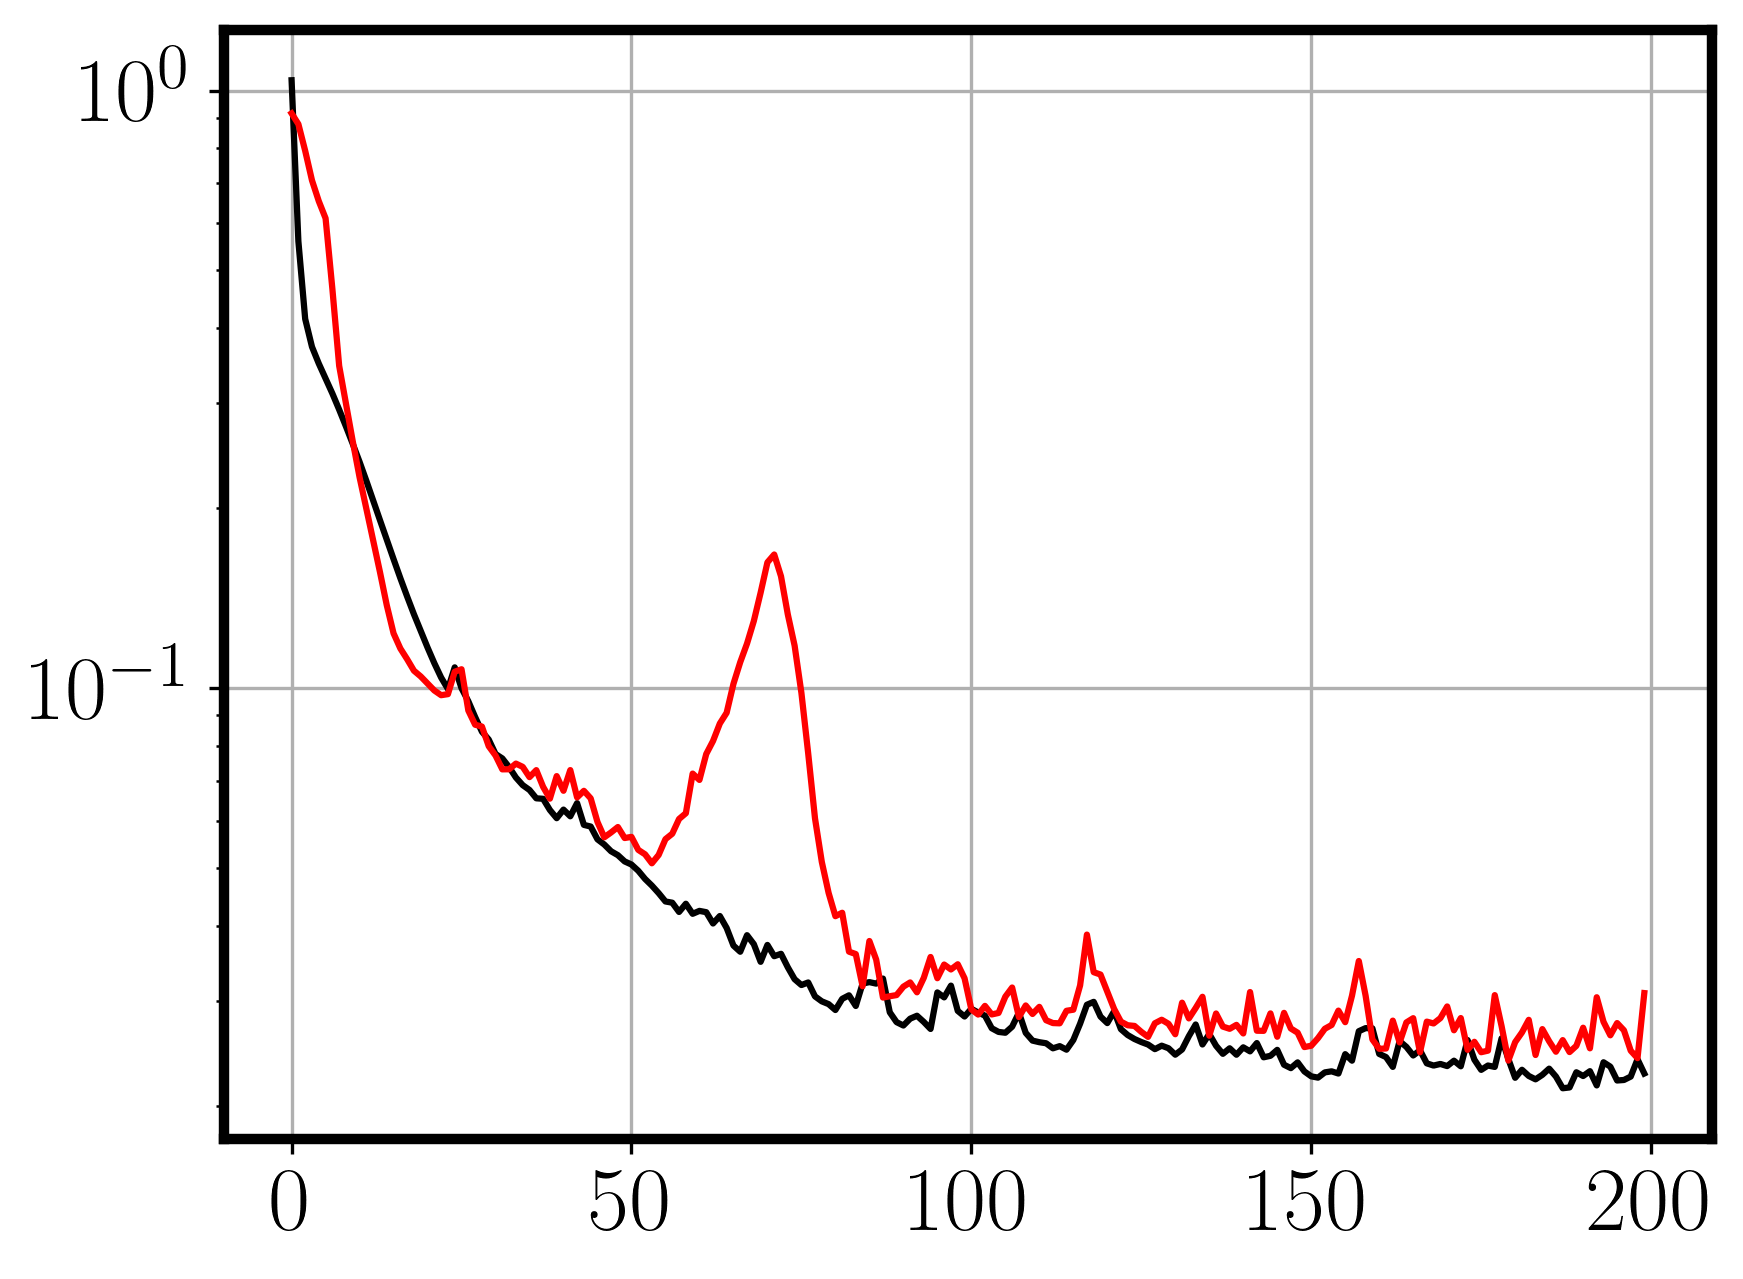

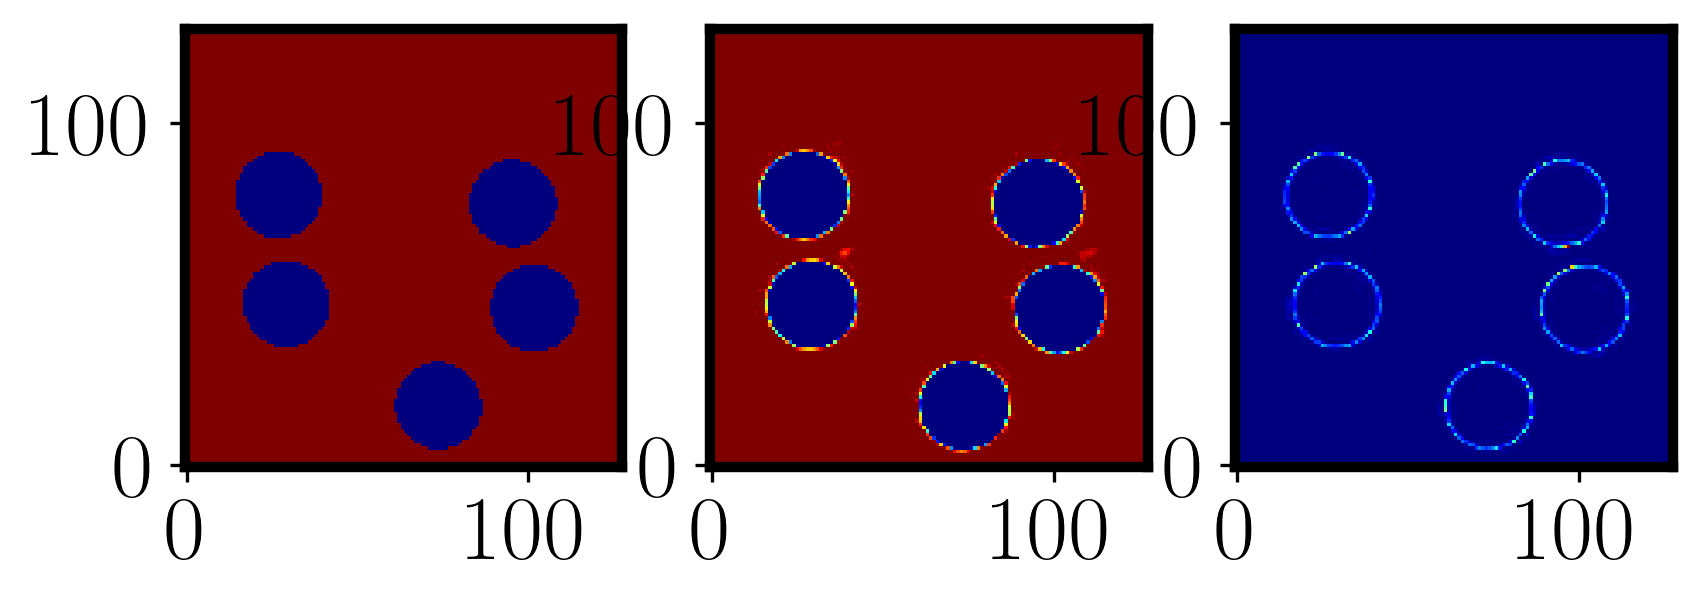

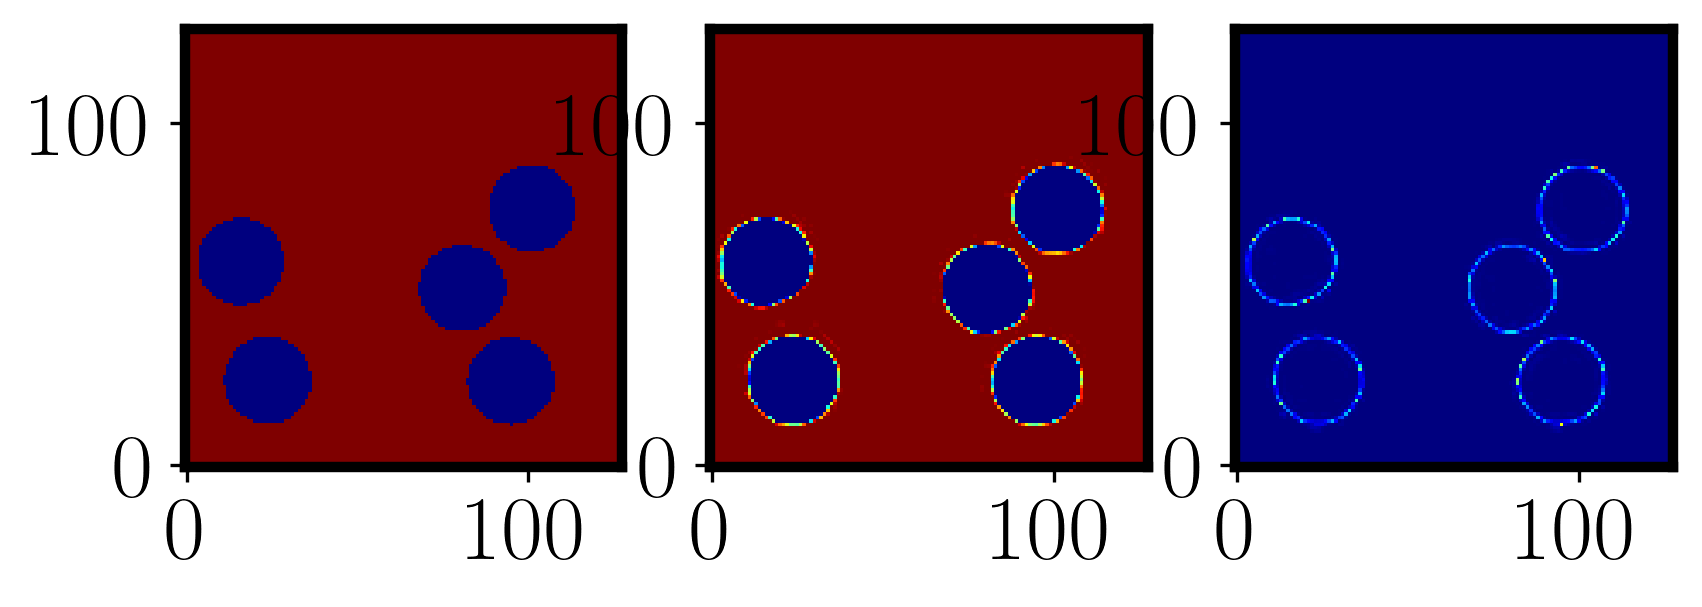

128


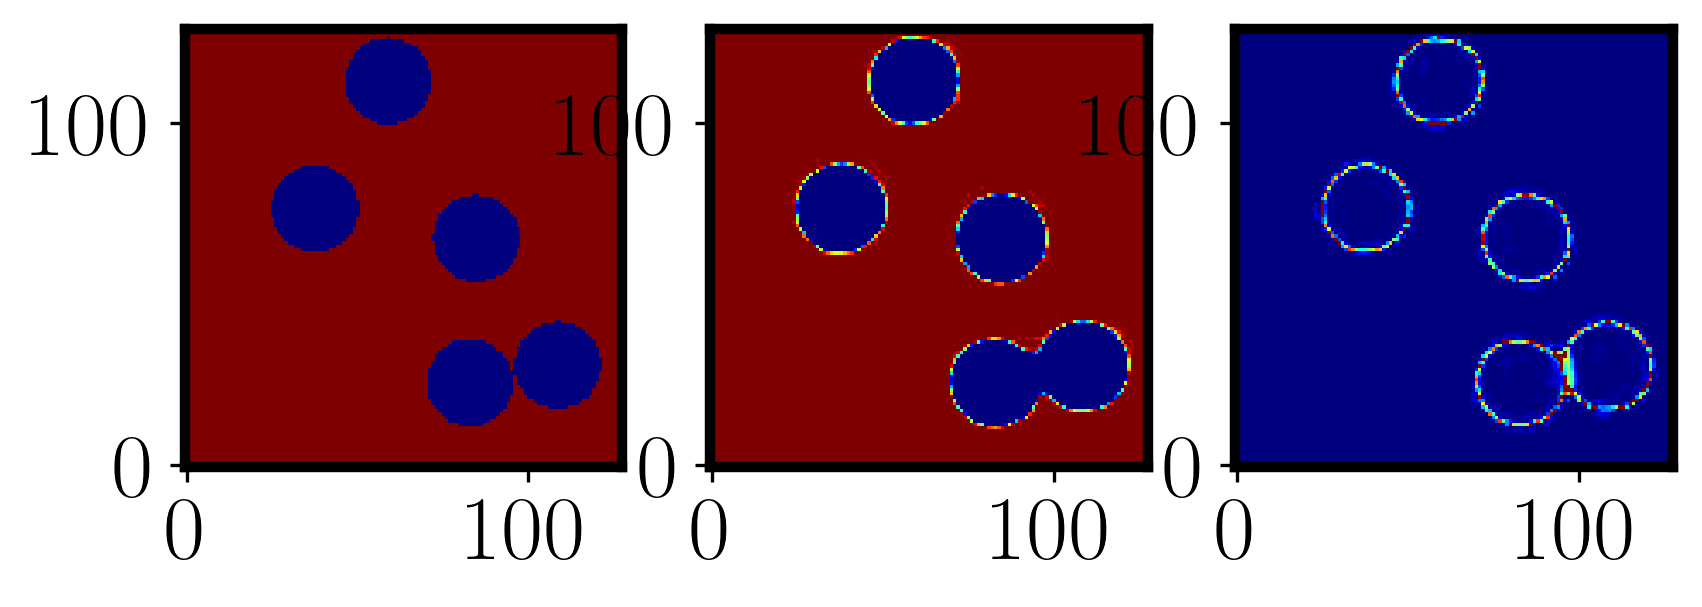

In [10]:

############################################################################### evaluation

model.eval()

print("validation cost: {:.2e} training cost: {:.2e}".format(np.min(costHistoryValidation), np.min(costHistoryTrain)))

fig, ax = plt.subplots()
ax.grid()
ax.plot(costHistoryTrain, 'k')
ax.plot(costHistoryValidation, 'r')
ax.set_yscale('log')
plt.show()


sample = next(iter(dataloaderTraining))
index = 0
fig, ax = plt.subplots(1,3)
ax[0].imshow(sample[index,0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[1].imshow(model(sample)[index,0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[2].imshow((sample[index,0].detach() - model(sample)[index,0].detach().cpu())**2, origin='lower', cmap='jet')
plt.show()

sample = next(iter(dataloaderValidation))
index = 0
fig, ax = plt.subplots(1,3)
ax[0].imshow(sample[index,0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[1].imshow(model(sample)[index,0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[2].imshow((sample[index,0].detach() - model(sample)[index,0].detach().cpu())**2, origin='lower', cmap='jet')
plt.show()

# ANOMOLOUS DATA
anomaly_dataset = anomalyDataset(degree=0)
print(len(anomaly_dataset))
anomalyPrediction = model(anomaly_dataset.data)

index = 0
fig, ax = plt.subplots(1,3)
ax[0].imshow(anomaly_dataset[index,0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[1].imshow(anomalyPrediction[index,0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[2].imshow((anomaly_dataset[index,0].detach() - anomalyPrediction[index,0].detach().cpu())**2, origin='lower', vmin=0, vmax=1, cmap='jet')
plt.show()


errors = np.zeros((6, len(anomaly_dataset.data)))
for degree in range(6):
    anomaly_dataset = anomalyDataset(degree)    
    anomalyPrediction = model(anomaly_dataset.data)
    errors[degree] = torch.mean((anomaly_dataset.data - anomalyPrediction)**2, dim=(1,2,3)).detach().cpu()

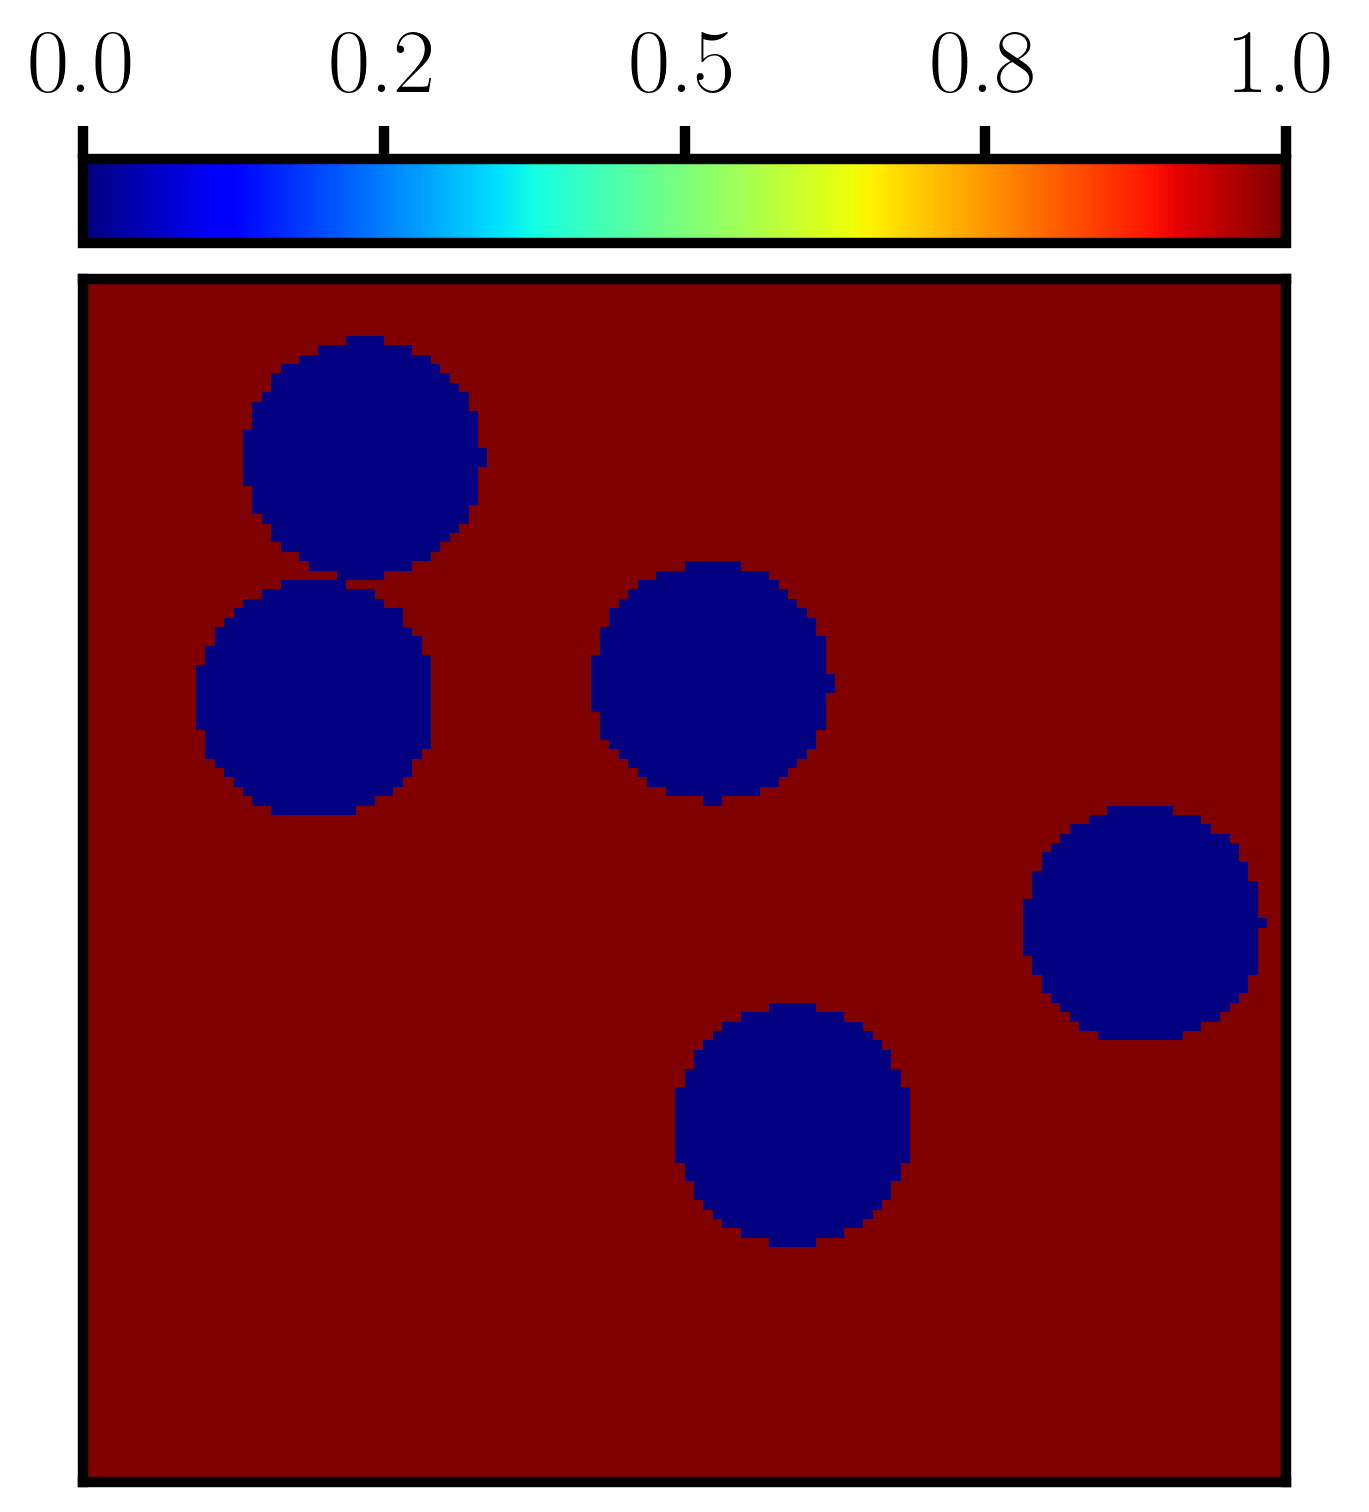

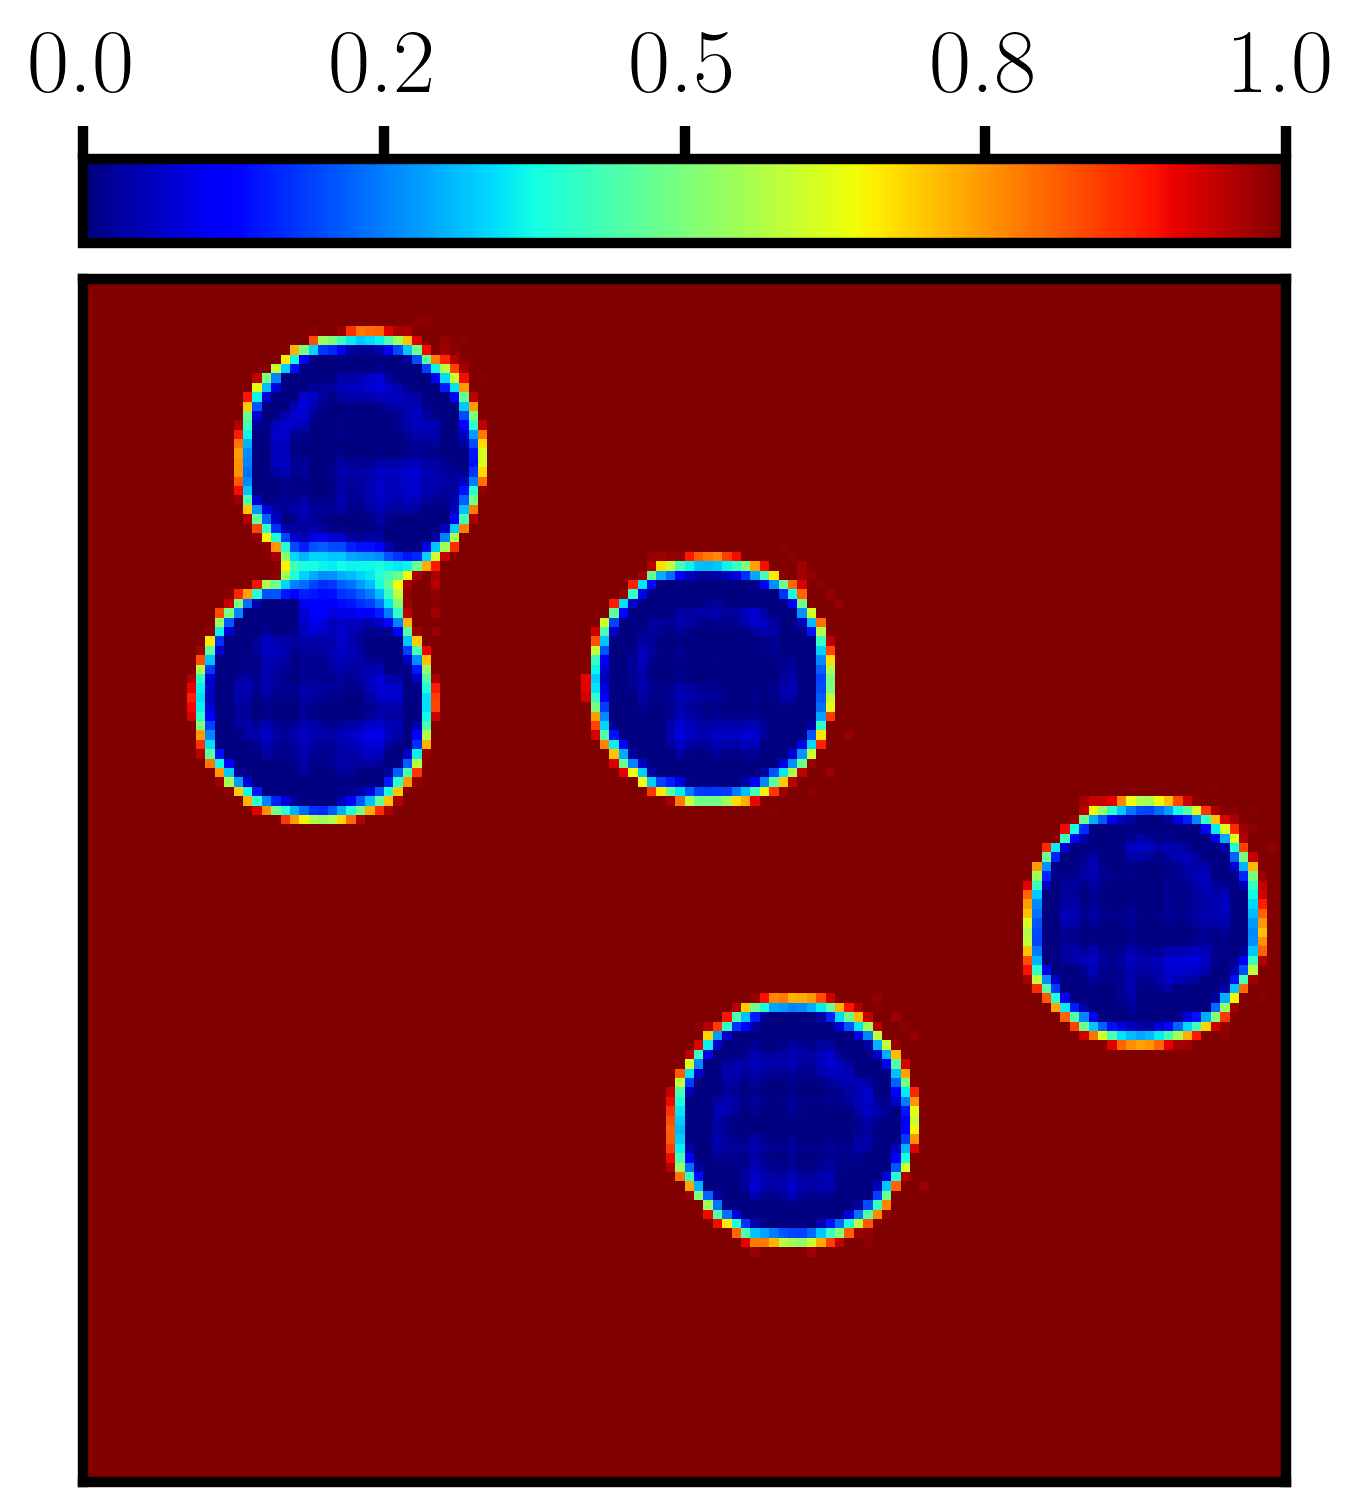

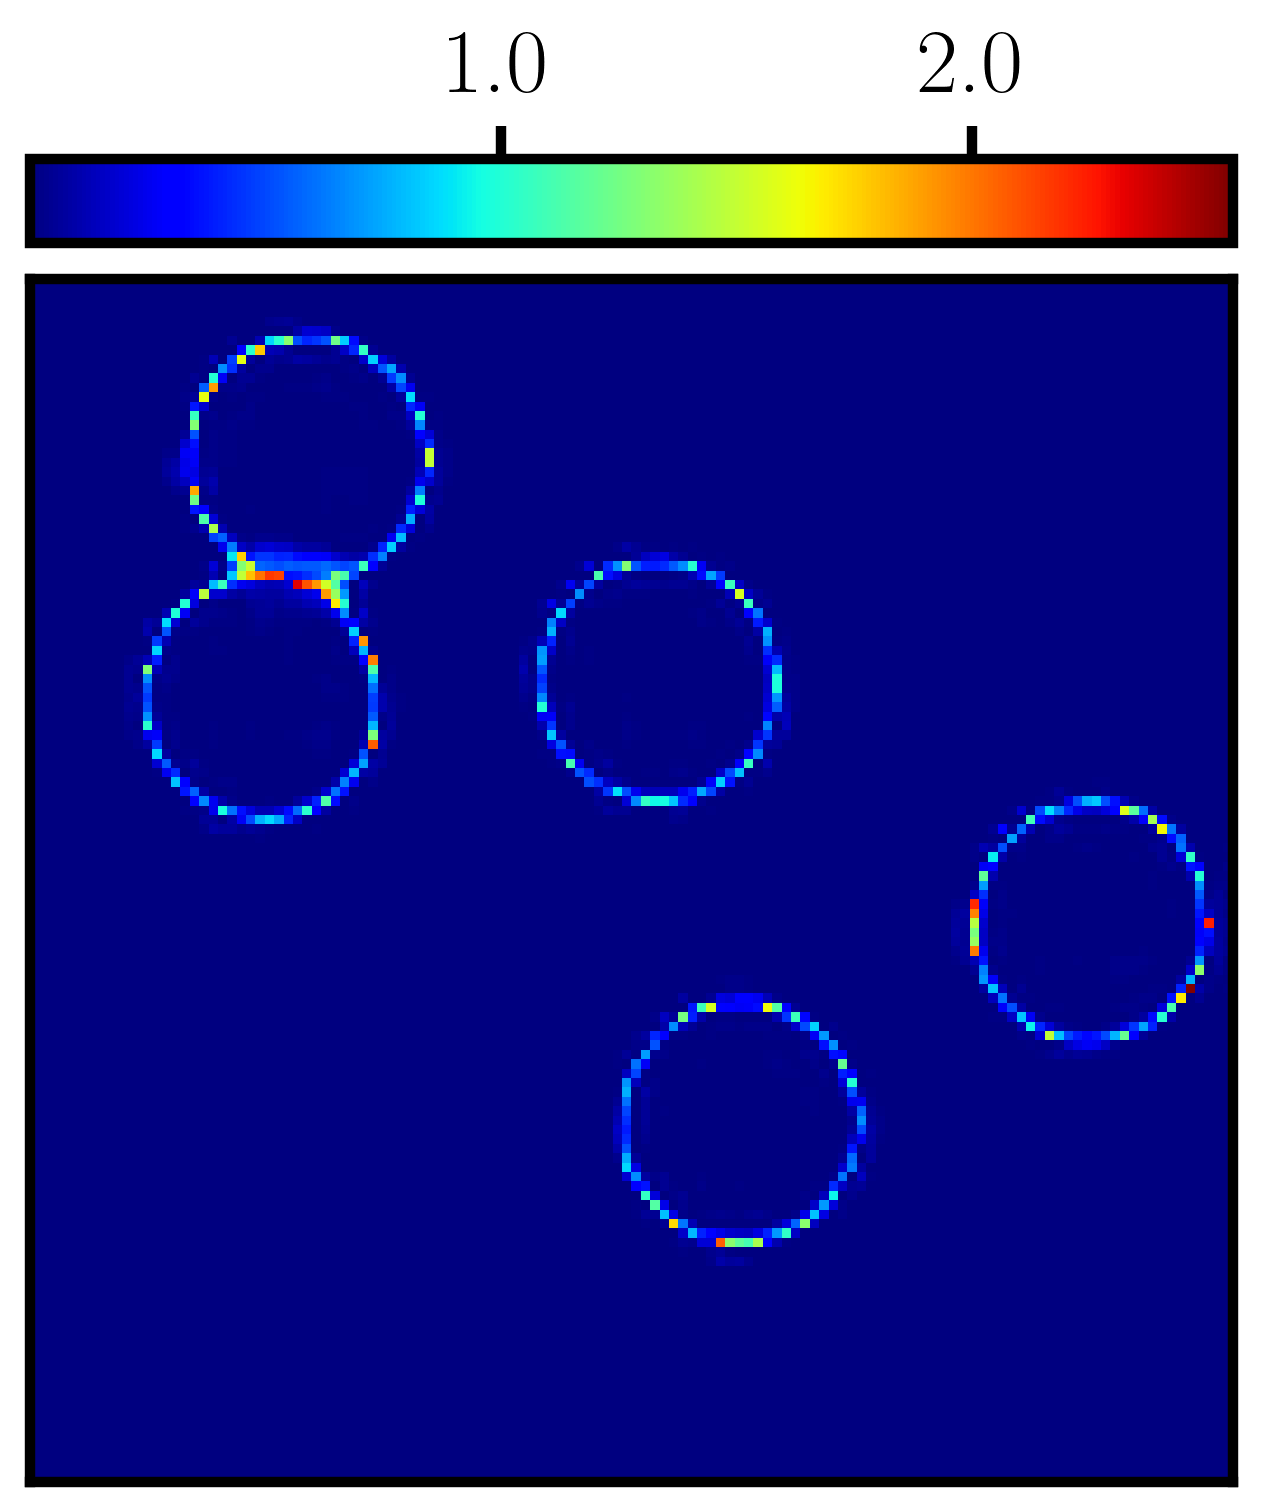

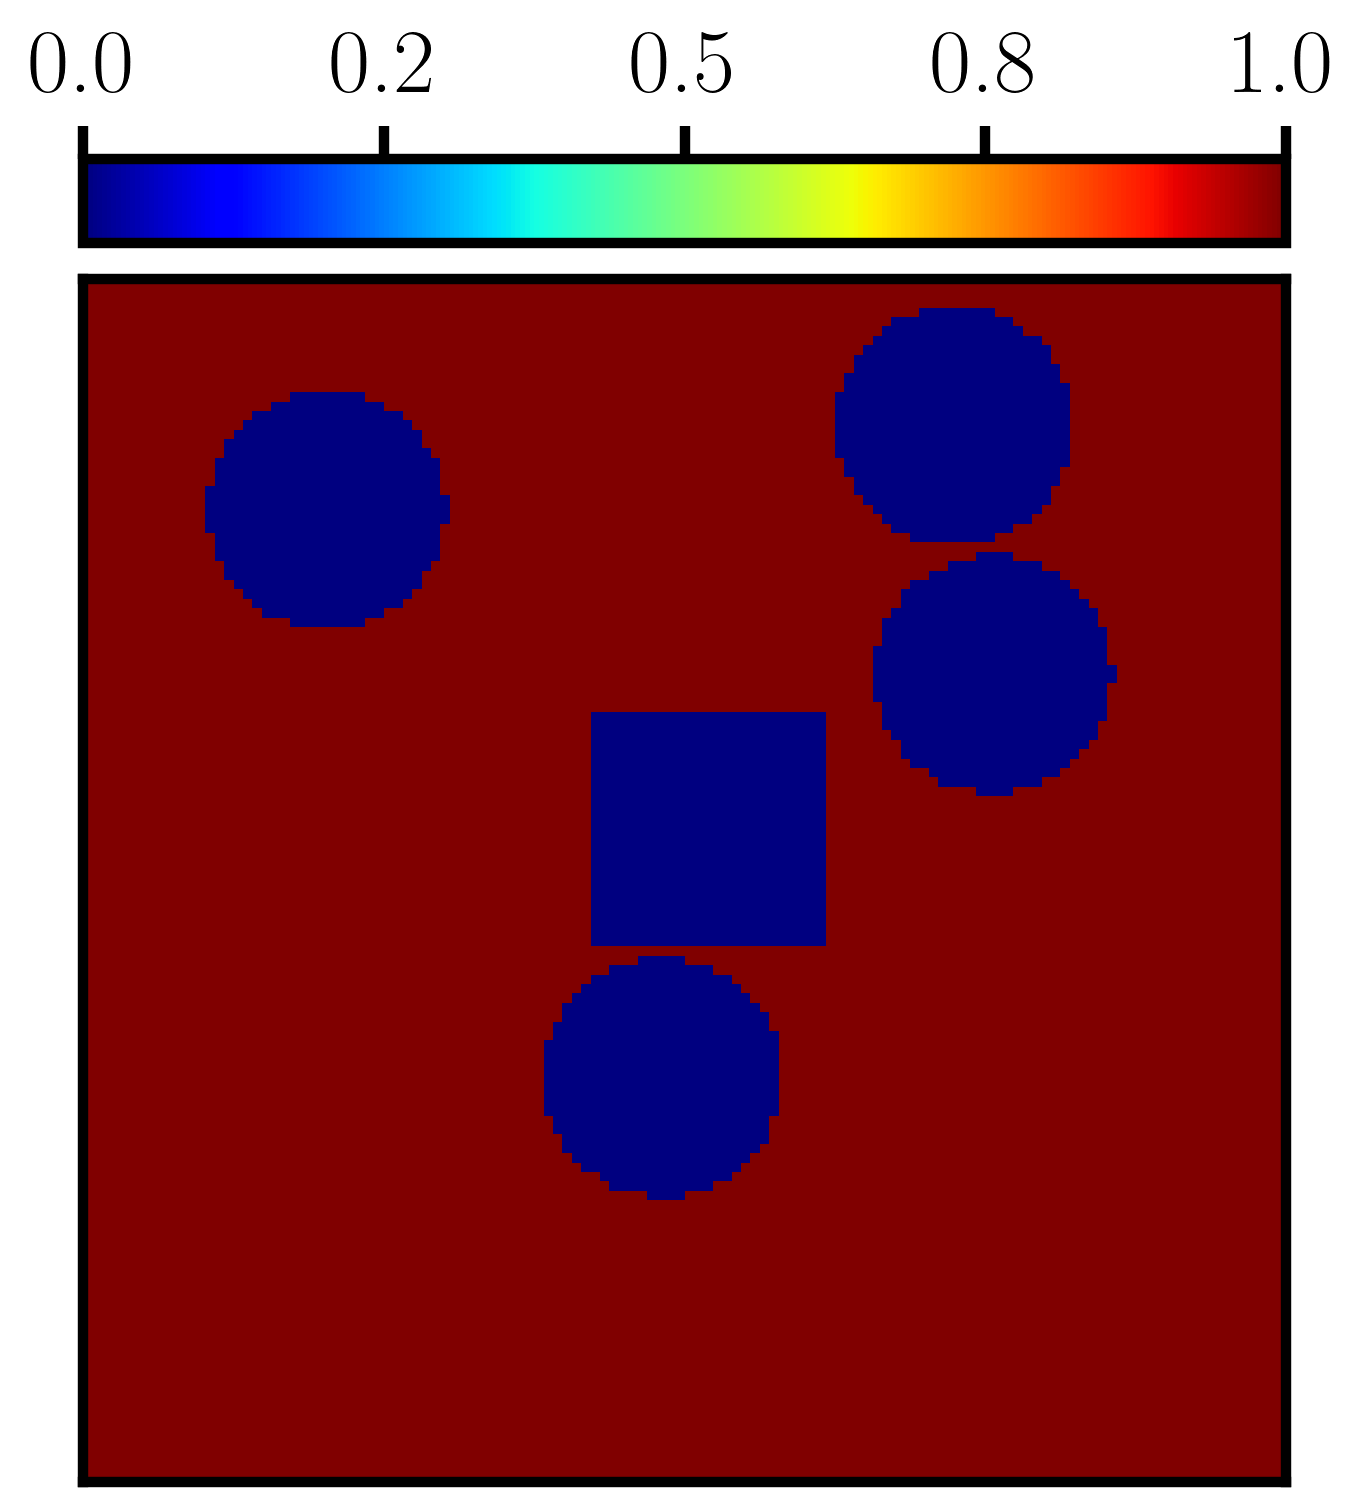

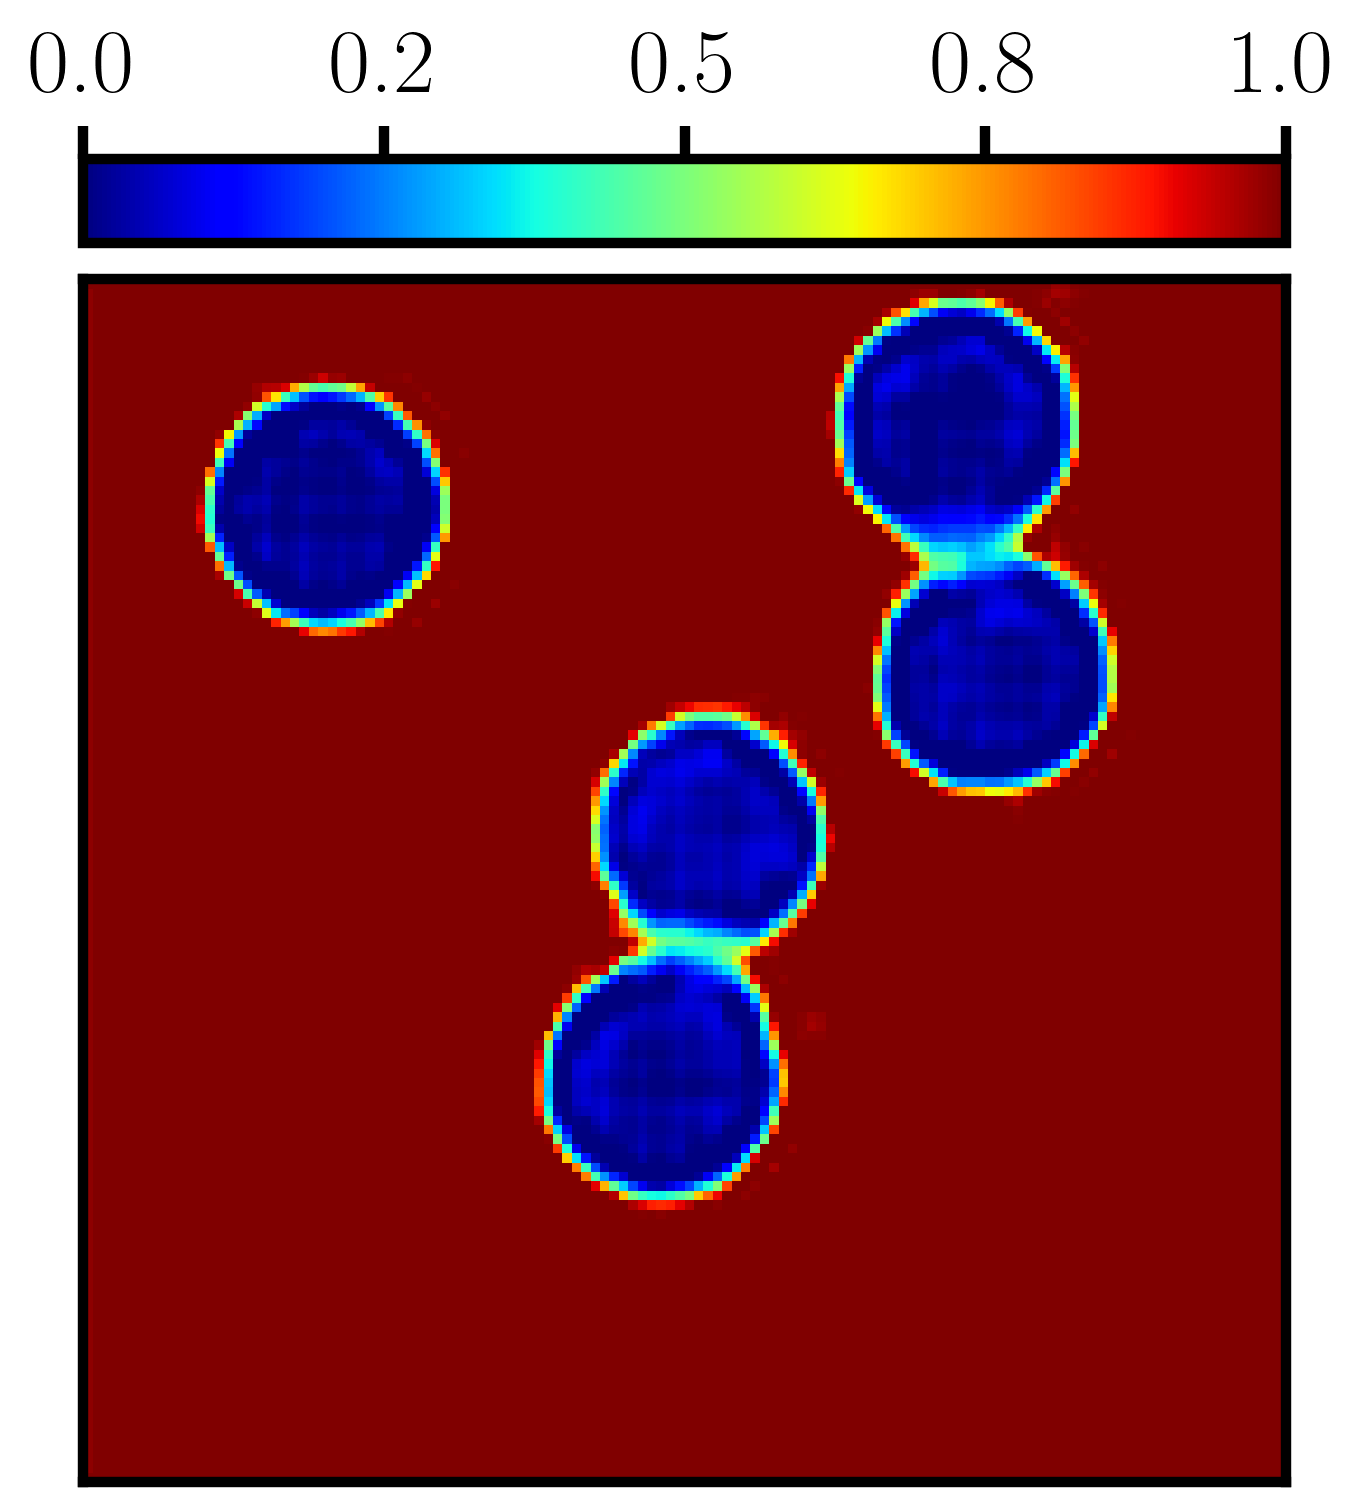

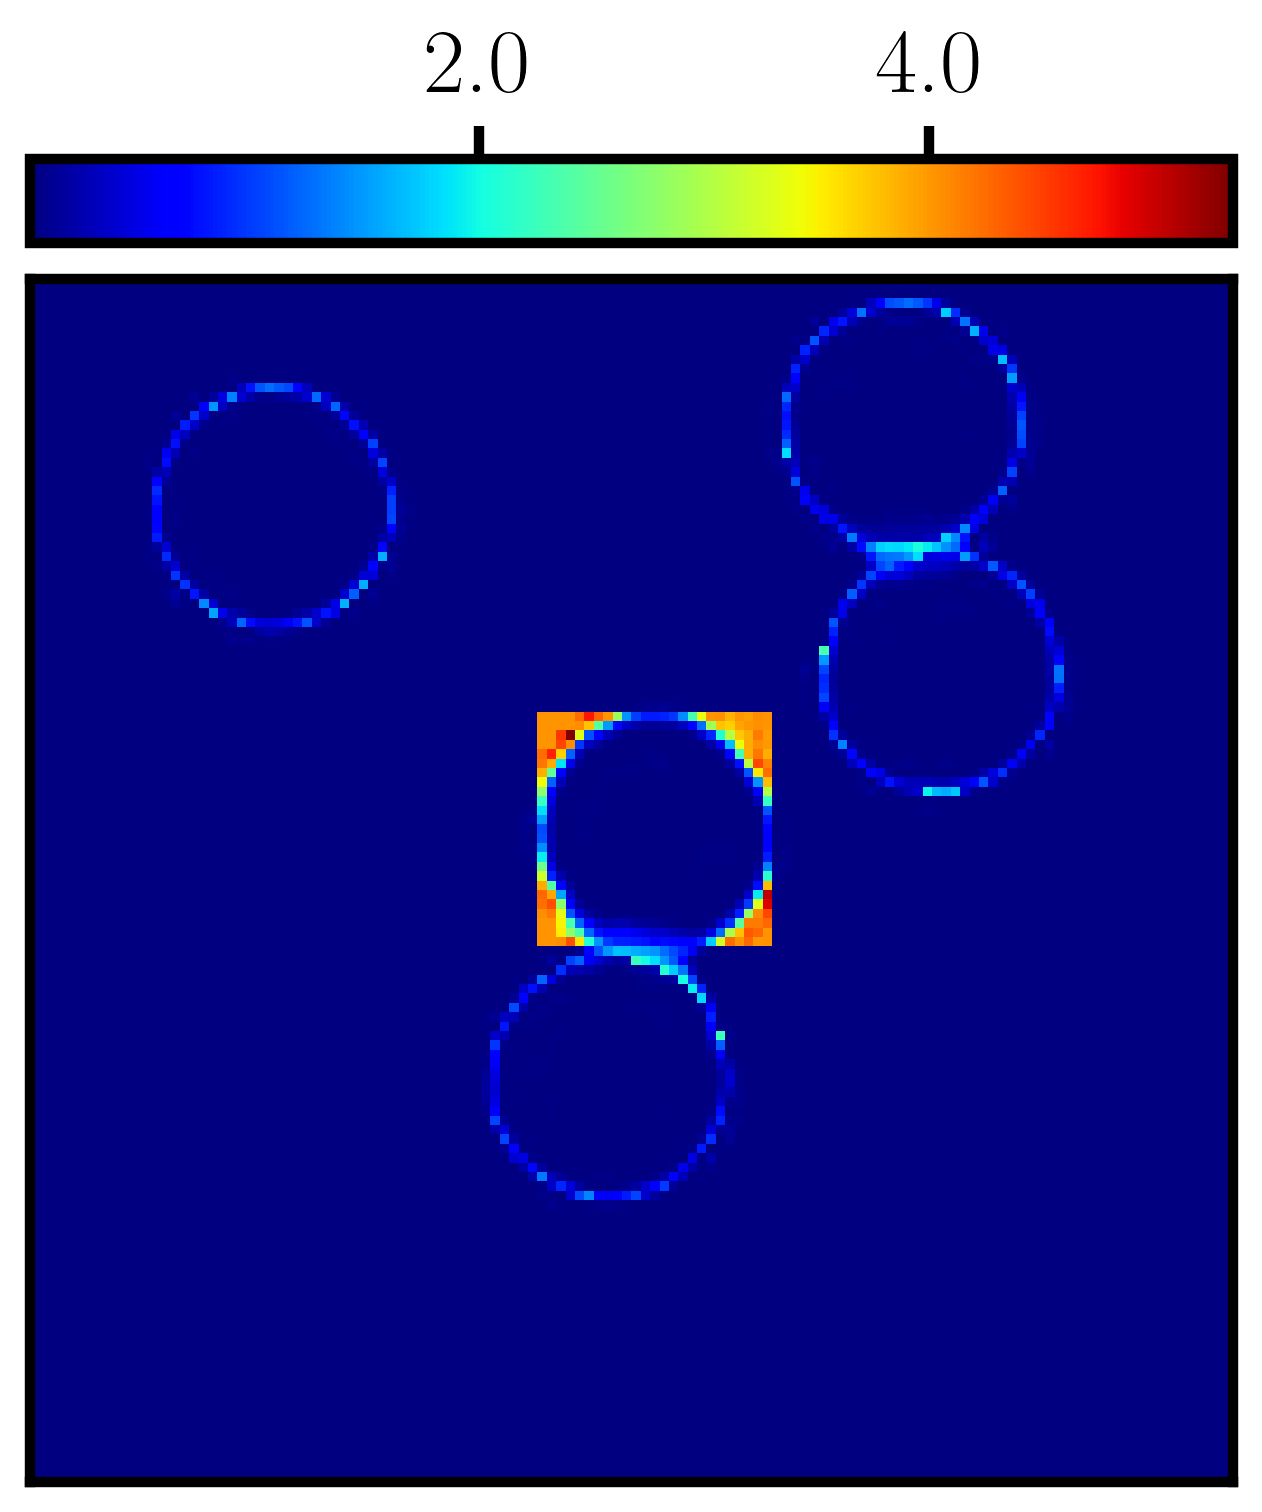

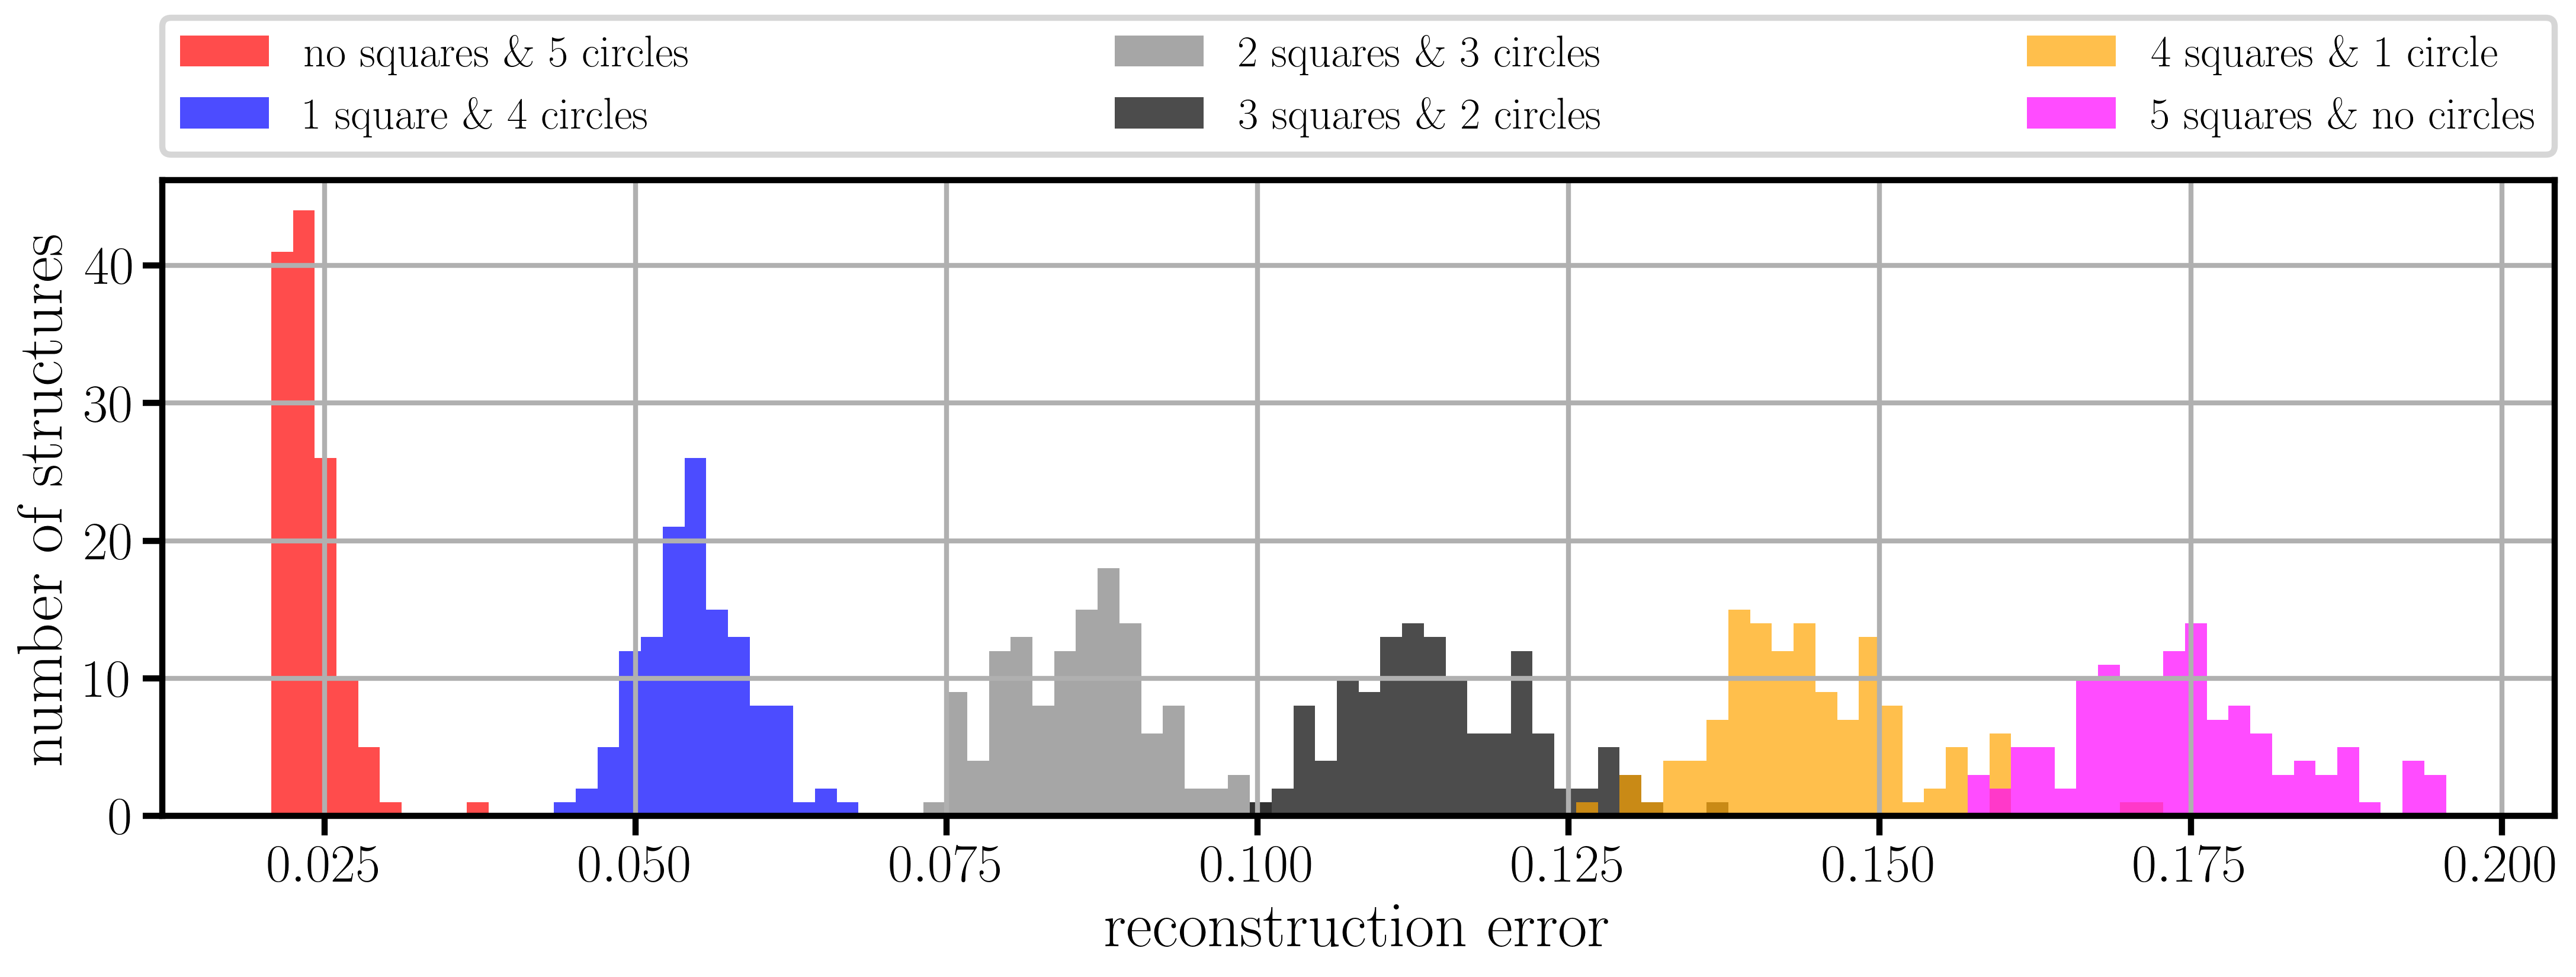

In [11]:

############################################################################### postprocessing
#############################
import matplotlib
import matplotlib.font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["axes.linewidth"] = 2.5
from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Computer Modern Roman"], "size": 22})
rc("text", usetex=True)
#############################

x = np.linspace(0,1,128)
y = np.linspace(0,1,128)
x, y = np.meshgrid(x, y, indexing='ij')

# normal
index = 0
sample = anomalyDataset(degree=0).data

# normal ground truth
fig, ax = plt.subplots(figsize=(5, 5 * 1.1))
ax.tick_params(width=2.5, length=8)
cp = ax.pcolormesh(x, y, sample[index,0].detach().cpu()/2+0.5, cmap=plt.cm.jet, vmin=0, vmax=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="7%", pad="3%")
cb = fig.colorbar(cp, cax=cax, format="%.1f", orientation="horizontal")
cax.xaxis.set_ticks_position("top")
#cb.locator = matplotlib.ticker.MaxNLocator(nbins=7)  # adjust nbins accoring to data
cb.update_ticks()
cb.ax.tick_params(width=2.5, length=8)

plt.minorticks_off()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig("output/normaltruth.pdf")
plt.show()

# normal reconstruction
fig, ax = plt.subplots(figsize=(5, 5 * 1.1))
ax.tick_params(width=2.5, length=8)
cp = ax.pcolormesh(x, y, model(sample)[index,0].detach().cpu()/2+0.5, cmap=plt.cm.jet, vmin=0, vmax=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="7%", pad="3%")
cb = fig.colorbar(cp, cax=cax, format="%.1f", orientation="horizontal")
cax.xaxis.set_ticks_position("top")
#cb.locator = matplotlib.ticker.MaxNLocator(nbins=7)  # adjust nbins accoring to data
cb.update_ticks()
cb.ax.tick_params(width=2.5, length=8)

plt.minorticks_off()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig("output/normalprediction.pdf")
plt.show()

# normal reconstruction error
fig, ax = plt.subplots(figsize=(5, 5 * 1.1))
ax.tick_params(width=2.5, length=8)
cp = ax.pcolormesh(x, y, (sample[index,0].detach() - model(sample)[index,0].detach().cpu())**2, cmap=plt.cm.jet)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="7%", pad="3%")
cb = fig.colorbar(cp, cax=cax, format="%.1f", orientation="horizontal")
cax.xaxis.set_ticks_position("top")
#cb.locator = matplotlib.ticker.MaxNLocator(nbins=7)  # adjust nbins accoring to data
cb.update_ticks()
cb.ax.tick_params(width=2.5, length=8)

plt.minorticks_off()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig("output/normalreconstructionerror.pdf")
plt.show()


# anomaly
index = 0
sample = anomalyDataset(degree=1).data

# normal ground truth
fig, ax = plt.subplots(figsize=(5, 5 * 1.1))
ax.tick_params(width=2.5, length=8)
cp = ax.pcolormesh(x, y, sample[index,0].detach().cpu()/2+0.5, cmap=plt.cm.jet, vmin=0, vmax=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="7%", pad="3%")
cb = fig.colorbar(cp, cax=cax, format="%.1f", orientation="horizontal")
cax.xaxis.set_ticks_position("top")
#cb.locator = matplotlib.ticker.MaxNLocator(nbins=7)  # adjust nbins accoring to data
cb.update_ticks()
cb.ax.tick_params(width=2.5, length=8)

plt.minorticks_off()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig("output/anomalytruth.pdf")
plt.show()

# normal reconstruction
fig, ax = plt.subplots(figsize=(5, 5 * 1.1))
ax.tick_params(width=2.5, length=8)
cp = ax.pcolormesh(x, y, model(sample)[index,0].detach().cpu()/2+0.5, cmap=plt.cm.jet, vmin=0, vmax=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="7%", pad="3%")
cb = fig.colorbar(cp, cax=cax, format="%.1f", orientation="horizontal")
cax.xaxis.set_ticks_position("top")
#cb.locator = matplotlib.ticker.MaxNLocator(nbins=7)  # adjust nbins accoring to data
cb.update_ticks()
cb.ax.tick_params(width=2.5, length=8)

plt.minorticks_off()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig("output/anomalyprediction.pdf")
plt.show()

# normal reconstruction error
fig, ax = plt.subplots(figsize=(5, 5 * 1.1))
ax.tick_params(width=2.5, length=8)
cp = ax.pcolormesh(x, y, (sample[index,0].detach() - model(sample)[index,0].detach().cpu())**2, cmap=plt.cm.jet)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="7%", pad="3%")
cb = fig.colorbar(cp, cax=cax, format="%.1f", orientation="horizontal")
cax.xaxis.set_ticks_position("top")
#cb.locator = matplotlib.ticker.MaxNLocator(nbins=7)  # adjust nbins accoring to data
cb.update_ticks()
cb.ax.tick_params(width=2.5, length=8)

plt.minorticks_off()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig("output/anomalyreconstructionerror.pdf")
plt.show()


# histogram

numberOfBins = 100
bins = np.histogram(errors, bins=numberOfBins)[1]
fig, ax = plt.subplots(figsize=(15, 6)) # potentially 5
ax.grid(linewidth=2)
ax.tick_params(width=2.5, length=8)

ax.hist(errors[0], bins=bins,  color='r', alpha=0.7, label='no squares \& 5 circles')
ax.hist(errors[1], bins=bins, color='b', alpha=0.7, label='1 square \& 4 circles')
ax.hist(errors[2], bins=bins, color='gray', alpha=0.7, label='2 squares \& 3 circles')
ax.hist(errors[3], bins=bins, color='k', alpha=0.7, label='3 squares \& 2 circles')
ax.hist(errors[4], bins=bins, color='orange', alpha=0.7, label='4 squares \& 1 circle')
ax.hist(errors[5], bins=bins, color='magenta', alpha=0.7, label='5 squares \& no circles')

ax.set_xlabel("reconstruction error", fontsize=26)
ax.set_ylabel("number of structures", fontsize=26)

legend = ax.legend(
    loc="lower left",
    bbox_to_anchor=(0, 1.04, 1, 1.04),
    mode="expand",
    borderaxespad=0,
    fancybox=True,
    shadow=False,
    ncol=3,
    fontsize=18,
)
legend.get_frame().set_linewidth(2.5)
plt.minorticks_off()
fig.tight_layout()
plt.savefig("output/autoencoderHistogram.pdf")
plt.show()
